# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 2 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 2 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [2]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,gmm,utils,config

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

In [3]:
labels = pd.read_csv(dir_data+'seq/sample_ids_merged_dup.csv')

labels.loc[labels.clone.isnull(),'type'] = 'population'
labels.loc[labels.clone.notnull(),'type'] = 'clone'

print labels['coverage'].quantile(.25), labels['coverage'].quantile(.75)
print labels['coverage'].min(), labels['coverage'].max()

23.5043072575 90.800547035
9.061720706 150.0955855


## Data import

Top panels - Import subclonal frequency

In [4]:
# load data
seq_st_df = utils.load_data(dir_data+'seq/subclonality/seq_subclonality.pickle')

# compute cumulative haplotype frequencies for major subclones
seq_st_df['clonal'] = seq_st_df.apply(lambda x: 
                                      x[['subclone A','subclone B','subclone C','subclone D']].fillna(0).sum(), 
                                      axis=1)
# calculate the remaining bulk fraction
seq_st_df['bulk'] = 1.0 - seq_st_df['clonal']

seq_st_df.head()

,background,cross,cross_rep,selection,selection_rep,subclone A,subclone B,subclone C,subclone D,time,population,sample,clonal,bulk
0,WAxNA,F12,2,RM,2,0.0200,NaN,NaN,NaN,2,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T2,0.0200,0.9800
1,WAxNA,F12,2,RM,2,0.0202,NaN,NaN,NaN,4,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T4,0.0202,0.9798
2,WAxNA,F12,2,RM,2,0.0705,NaN,NaN,NaN,8,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T8,0.0705,0.9295
3,WAxNA,F12,2,RM,2,0.1098,NaN,NaN,NaN,16,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T16,0.1098,0.8902
4,WAxNA,F12,2,RM,2,0.1097,NaN,NaN,NaN,32,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T32,0.1097,0.8903


Middle panels - Import mutation counts

In [5]:
# load data
seq_dn_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

print seq_dn_df.shape
seq_dn_df.head()

(572, 79)


,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chrom,...,selection,selection_rep,time,clone,population,coverage,substitution,assignment,mutation_type,consequence_short
0,1,0.1,[A],2,NaN,NaN,NaN,1.093,NaN,7,...,HU,1,16,,NA_HU_1,57.370612,G>A,bulk,passenger,NaN
1,0,0.1,[A],2,A,K/M,protein_coding,-0.027,341,7,...,HU,1,16,,NA_HU_1,57.370612,T>A,bulk,driver,non-synonymous
2,0,0.1,[A],2,A,R/I,protein_coding,-1.198,101,7,...,HU,1,16,,NA_HU_1,57.370612,C>A,bulk,driver,non-synonymous
3,1,0.1,[T],2,NaN,NaN,NaN,0.395,NaN,12,...,HU,1,16,,NA_HU_1,57.370612,C>T,bulk,passenger,NaN
4,1,0.1,[A],2,A,G,protein_coding,0.956,861,14,...,HU,1,16,,NA_HU_1,57.370612,C>A,bulk,passenger,synonymous


Bottom panels - Import phenotype evolution

In [6]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'ancestral')|\
                    (pheno_df.group == 'evolved')]

groups_1 = pheno_df.groupby(['group','cross','cross_rep','selection','selection_rep'])
pheno_df = pheno_df[pheno_df.selection_rep != '']

for (ii,((group,cross,cross_rep,selection,selection_rep),g1)) in enumerate(groups_1):
    
    if group=='evolved':
        df = groups_1.get_group(('ancestral',cross,cross_rep,selection,''))        
        df['selection_rep'] = df.selection_rep.replace([''],[selection_rep])
        df['population'] = df['background']+'_'+df['cross']+'_'+df['cross_rep'].apply(str)+'_'+df['selection']+'_'+df['selection_rep'].apply(str)

        pheno_df = pheno_df.append(df)
        
pheno_df = pheno_df.reset_index(drop=True)

# set reference as mean phenotype of the ancestral hybrid
def norm(df):
    df['growth_rate'] = df['growth_rate'] - df[df.group=='ancestral'].growth_rate.mean()
    return df

pheno_df = pheno_df.groupby(['selection','environment','population'], as_index=False).apply(norm)
        
# # filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','group',\
#                                     'population','isolate','genotype_long'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head()  # show dataframe header to stdout

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,selection,environment,run,index,plate,row,column,group,population,background,...,time,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,growth_rate
0,HU,HU,1,2,0,0,2,evolved,WAxNA_F12_1_HU_3,WAxNA,...,32,,1,,+/+,,,MATa/α,,-0.079774
1,HU,HU,1,3,0,0,3,evolved,WAxNA_F12_2_HU_3,WAxNA,...,32,,1,,+/+,,,MATa/α,,-0.097435
2,HU,HU,1,6,0,0,6,evolved,WAxNA_F12_1_HU_3,WAxNA,...,32,,2,,+/+,,,MATa/α,,0.067773
3,HU,HU,1,7,0,0,7,evolved,WAxNA_F12_2_HU_3,WAxNA,...,32,,2,,+/+,,,MATa/α,,0.029800
4,HU,HU,1,10,0,0,10,evolved,WAxNA_F12_1_HU_3,WAxNA,...,32,,3,,+/+,,,MATa/α,,0.063496


## Figure 2 - Subclonal heterogeneity

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


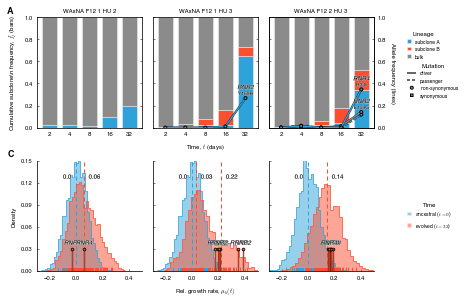

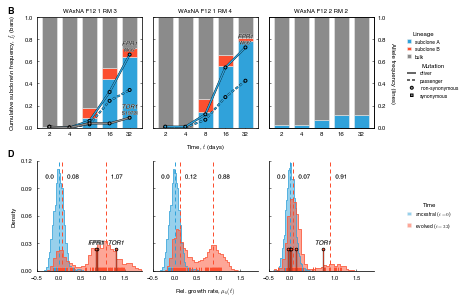

In [7]:
param = 'growth_rate'

panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':1,
    'WAxNA_F12_2_HU_3':2,
    'WAxNA_F12_1_RM_3':0,
    'WAxNA_F12_1_RM_4':1,
    'WAxNA_F12_2_RM_2':2
}

groups_st = seq_st_df[seq_st_df.population.isin(panels.keys())]
groups_dn = seq_dn_df[(seq_dn_df.population.isin(panels.keys()))&\
                      (seq_dn_df.clone=='')]
groups_ph = pheno_df[pheno_df.population.isin(panels.keys())]

groups_st = groups_st.groupby('selection')
groups_dn = groups_dn.groupby('selection')
groups_ph = groups_ph.groupby(['selection','environment'])

for (ii, env) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=300, sharey='row')
    
    fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.3,wspace=0.1)
    
    # set scales
    for ax in axes[0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
    for ax in axes[1]:
        if env=='HU':
            ax.set_xlim(-0.3, 0.5)
            ax.set_ylim(0, 0.15)
        elif env=='RM':
            ax.set_xlim(-0.5, 1.9)
            ax.set_ylim(0, 0.12)

    ### top panels ###
    # de novo mutations #
    for (jj, (population, gdn)) in enumerate(groups_dn.get_group(env).groupby('population')):
        
        # retrieve axes
        ax1 = axes[0][panels[population]]
        
        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]
            
            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            
            ax1.plot(gdx.index.values, gdx.frequency.values,
                     color=config.lineages[assignment]['fill'], 
                     **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                             config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax1.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                             textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax1.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                             xy=(index,gdx.frequency[index]), fontsize=5,
                             textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
    
    # subclonal frequency #
    for (jj, (population,gst)) in enumerate(groups_st.get_group(env).groupby('population')):

        # retrieve axes
        ax2 = axes[0][panels[population]]

        # 
        ax2.set_title(population.replace('_',' '), fontsize=6)
        # 
        gst.set_index('time', inplace=True)
        colors=[config.lineages[x]['fill'] for x in ['subclone A','subclone B','bulk']]
        gst[['subclone A','subclone B','bulk']].plot(ax=ax2, kind='bar', legend=False, 
                                                     stacked=True, rot=0, width=0.75, position=0.5,
                                                     color=colors)
        
        # rotate the x-axis ticks
        ax2.set_xlabel('', rotation=0)

    ### bottom panels ###
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):

        # retrieve axes
        ax3 = axes[1][panels[population]]
        utils.simple_axes(ax3)
        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
                                    
        for (kk, (time, g3)) in enumerate(gph.groupby('group')):
            
            x, y = plot.histogram_binned_data(ax, g3[param], bins=34)

            ax3.plot(x, y, color=config.population['color'][time], linewidth=0.75)
            
            ax3.fill_between(x, 0, y, label=config.population['long_label'][time], 
                             alpha=0.5, facecolor=config.population['color'][time])
            
            data_reduced = g3.groupby('isolate').agg([np.mean])
            X = data_reduced[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
                        
            models = gmm.gmm_fit(X, N)
            
            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]
        
            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax3.plot( [p,p], ax3.get_ylim(), 
                         color=config.population['color'][time], 
                         linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction                    
                ax3.annotate(np.around(p, 2),
                            xy=(p, 0.85), xycoords=trans, fontsize=6,
                            color='k', va='center',
                            ha=('right' if time=='ancestral' else 'left'),
                            xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
            
            data_ns = g3.groupby(['isolate']).agg([np.mean, np.median, np.std, 'count'])
            
            x_data = np.array(data_ns[param]['mean'])
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', config.population['color'][time], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=config.population['color'][time], 
                     path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')

            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax3.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
    # set axes labels
    axes[0, 1].set_xlabel(r'Time, $t$ (days)')
    axes[0, 0].set_ylabel(r'Cumulative subclone\n frequency, $f_j$ (bars)')
    axes[0, 2].twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
    axes[1, 1].set_xlabel(r'Rel. growth rate, $\mu_{k}(t)$')
    axes[1, 0].set_ylabel('Density')

    # set legends
    leg1 = axes[0, 2].legend(bbox_to_anchor=(1.3, 0.75), frameon=False,
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Lineage', prop={'size':5})

    driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                 **config.mutation_type['driver'])
    passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                    **config.mutation_type['passenger'])
    nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                                 linestyle='', linewidth=1.5,
                                 path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                 **config.consequence_short['non-synonymous'])
    syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'],
                              linestyle='', linewidth=1.5,
                              path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")], 
                              **config.consequence_short['synonymous'])
    leg2 = axes[0, 2].legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 0.25), ncol=1,
                             frameon=False, loc='lower left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
    axes[0, 2].add_artist(leg1)
    
    leg3 = axes[1, 2].legend(bbox_to_anchor=(1.3, 0.5), frameon=False, 
                             loc='center left', borderaxespad=0., framealpha=1,
                             handlelength=0.75, title='Time', prop={'size':5})
    
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(),fontsize=6)
    
    # set panel labels
    axes[0][0].text(-0.22, 1.1,  chr(ii + ord('A')), transform=axes[0][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')
    axes[1][0].text(-0.22, 1.1,  chr(ii + ord('C')), transform=axes[1][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')

    # axes limits
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(0.75)
        
        if ax.is_last_row():
            if env=='HU':
                ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            elif env=='RM':
                ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.png' % env, dpi=300, bbox_inches='tight')
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.svg' % env, dpi=300, bbox_inches='tight')
    plt.show()

**Fig. 2:** Reconstruction of subclonal dynamics. (**A** and **B**) Competing subclones evolved in hydroxyurea (A) and rapamycin (B) experienced a variety of fates. Time is on the $x$-axis, starting after crossing when the population has no competing subclones. Cumulative haplotype frequency of subclones (bars) and allele frequency of de novo mutants (lines) are on the -axis. Most commonly, selective sweeps were observed where a spontaneous mutation arose and increased in frequency. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. (**C** and **D**) Variability in intra-population growth rate, estimated by random sampling of 96 individuals at initial (0 days, blue) and final (32 days, red) time points ($n = 32$ technical replicates per individual). Mean growth rates by individual are shown at the foot of the histogram (Fig. S7). The posterior means of the distribution modes fitted by a Gaussian mixture model are indicated as dashed lines. The fittest individuals (pins) carry driver mutations, measured by targeted sampling and sequencing.

## Figure S4 - Sequence evolution of WA, NA founders

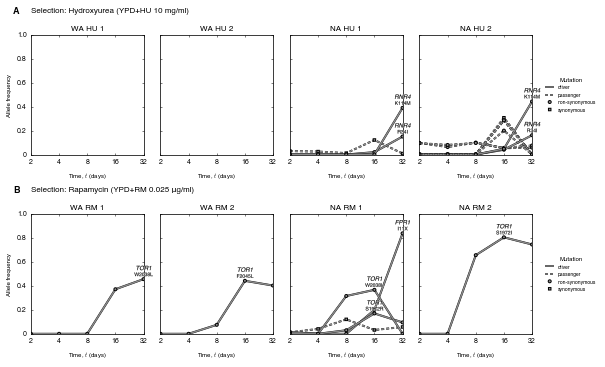

In [8]:
panels = {
    'HU': {
        'WA_HU_1':(0,0),
        'WA_HU_2':(0,1),
        'NA_HU_1':(0,2),
        'NA_HU_2':(0,3),
    },
    'RM': {
        'WA_RM_1':(0,0),
        'WA_RM_2':(0,1),
        'NA_RM_1':(0,2),
        'NA_RM_2':(0,3),
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations)) & \
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(8, 5), dpi=300)

grid = gridspec.GridSpec(2, 1, hspace=0.5)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 1
    ncols = 4
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             wspace=0.15)

    ### de novo mutations ###
    for (jj, p) in enumerate(panels[e].keys()):
        
        # retrieve axes
        ax = plt.subplot(gs[e][panels[e][p]])
        ax.set_title(p.replace('_',' '), fontsize=8)
    
        # set axes labels
        if (e,p) in [('HU','WA_HU_1'),('RM','WA_RM_1')]:
            ax.set_ylabel('Allele frequency')
            ax.text(-0.1, 1.2, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.text(0, 1.2, 'Selection: %s' % config.selection['long_label'][e], 
                    transform=ax.transAxes, fontsize=8, va='center', ha='left')
            ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(r'Time, $t$ (days)')
        
        if (e,p) in [('HU','NA_HU_2'),('RM','NA_RM_2')]:
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg1 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.1, 0.5), ncol=1,
                             frameon=False, loc='center left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
            plt.setp(leg1.get_title(),fontsize=6)
        
        if (e,p) in groups_dn.groups.keys():
            gdn = groups_dn.get_group((e,p))
        else:
            continue

        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]

            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            gdx = gdx.set_index('time')
            
            ax.plot(gdx.index, gdx.frequency,
                    color=config.lineages['bulk']['line'], 
                    **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                            config.consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                            textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                            xy=(index,gdx.frequency[index]), fontsize=5,
                            textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)

# axes limits
for ax in fig.get_axes():
        
    # set scales
    ax.set_xlim(2, 32)
    ax.set_ylim(0, 1)
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
    ax.set_xscale('log', base=2)
    ax.set_xticks([2, 4, 8, 16, 32])
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_parents.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_parents.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S4:** Subclonal dynamics in time for WA and NA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. WA founders evolved in hydroxyurea did not survive after 4 days. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S5 - Sequence evolution of WAxNA founders

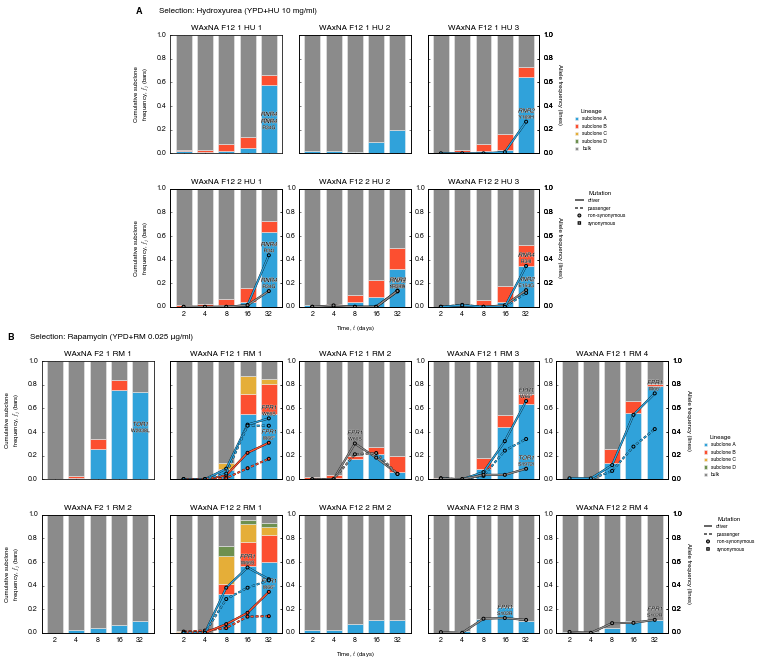

In [9]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':(0,1), 
        'WAxNA_F12_1_HU_2':(0,2), 
        'WAxNA_F12_1_HU_3':(0,3), 
        'WAxNA_F12_2_HU_1':(1,1), 
        'WAxNA_F12_2_HU_2':(1,2), 
        'WAxNA_F12_2_HU_3':(1,3)
    },
    'RM': {
        'WAxNA_F2_1_RM_1':(0,0),
        'WAxNA_F12_1_RM_1':(0,1), 
        'WAxNA_F12_1_RM_2':(0,2), 
        'WAxNA_F12_1_RM_3':(0,3), 
        'WAxNA_F12_1_RM_4':(0,4),
        'WAxNA_F2_1_RM_2':(1,0),
        'WAxNA_F12_2_RM_1':(1,1), 
        'WAxNA_F12_2_RM_2':(1,2), 
        'WAxNA_F12_2_RM_3':(1,3), 
        'WAxNA_F12_2_RM_4':(1,4)
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)].groupby(['selection','population'])
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(10, 10), dpi=300)

grid = gridspec.GridSpec(2, 1)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 2
    ncols = 5
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0.3, wspace=0.15)
    
    for (jj, p) in enumerate(panels[e]):
        
        # retrieve axes
        ax = plt.subplot(gs[e][panels[e][p]])
        
        ### de novo mutations ###
        if (e,p) in groups_dn.groups.keys():

            gdn = groups_dn.get_group((e,p))
            
            for (gene, pos, cds, sub, protein_pos, amino_acids, consequence), gdx \
            in gdn.groupby(['gene','pos','cds_position','substitution','protein_position','amino_acids','consequence_short']):

                assignment = gdx.assignment.unique()[0]
                mutation_type = gdx.mutation_type.unique()[0]
            
                gdx.time = gdx.time.apply(int)
                gdx = gdx.sort_values('time').reset_index(drop=True)
                gdx = gdx.sort_index()

#                 ax.plot(gdx.index.values, gdx.frequency.values,
#                         color=config.lineages[assignment]['line'],
#                         **utils.merge_two_dicts(config.mutation_type[mutation_type],
#                                                 config.consequence_short[consequence]))
                gdx.frequency.plot(ax=ax, secondary_y=True, 
                                   color=config.lineages[assignment]['line'],
                                   **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                                           config.consequence_short[consequence]))
            
            
                if mutation_type=='driver':
                    index = np.argmax(gdx.frequency)
                    ax.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                                textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                                path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                    ax.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                                xy=(index,gdx.frequency[index]), fontsize=5,
                                textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                                path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)

        ### subclone frequency ###
        gst = groups_st.get_group((e,p))
        
        # 
        ax.set_title(p.replace('_',' '), fontsize=8)
        # 
        gst = gst.set_index('time')
        gst = gst[['subclone A','subclone B','subclone C','subclone D','bulk']]
        gst.plot(ax=ax, kind='bar',
                 legend=False, stacked=True, width=0.75, position=0.5,
                 color=[config.lineages[c]['fill'] for c in gst.columns])
        
        # rotate the x-axis ticks
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
        ax.set_xlabel('')
                
        # legends
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4')]:
            
            leg1 = ax.legend(bbox_to_anchor=(1.3, 0), ncol=1,
                             frameon=False, loc='lower left', 
                             borderaxespad=0., handlelength=0.7, 
                             title='Lineage', prop={'size':5})
            plt.setp(leg1.get_title(),fontsize=6)
    
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg2 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 1), ncol=1,
                             frameon=False, loc='upper left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
            plt.setp(leg2.get_title(),fontsize=6)

        if (e,p) in [('HU','WAxNA_F12_2_HU_2'),('RM','WAxNA_F12_2_RM_2')]:
            ax.set_xlabel('Time, $t$ (days)')
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1'),
                     ('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F2_1_RM_2')]:
            ax.set_ylabel('Cumulative subclone\n frequency, $f_j$ (bars)')
        else:
            ax.set_yticklabels([])
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4'),
                     ('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
#             ax.set_yticklabels([])
#             ax2 = ax.twinx()
            ax.twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
            ax.twinx().set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
#             plt.setp( ax.twinx().xaxis.get_majorticklabels(), rotation=0 )
        else:
            ax.twinx().set_yticklabels([])

#         ax2.set_zorder(ax.get_zorder()-1) # put ax in front of ax2

    # set panel labels
    ax = plt.subplot(gs[e][((0,1) if e == 'HU' else (0,0))])
    ax.text(-0.25, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=9, fontweight='bold', va='center', ha='right')
    ax.text(-0.1, 1.2, 'Selection: %s' % config.selection['long_label'][e],
            transform=ax.transAxes, fontsize=8, va='center', ha='left')
    
# axes limits
for ax in fig.get_axes():
            
    ax.set_ylim(0, 1)

    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
            
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.75)

fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.svg', dpi=300, bbox_inches='tight')
plt.show()

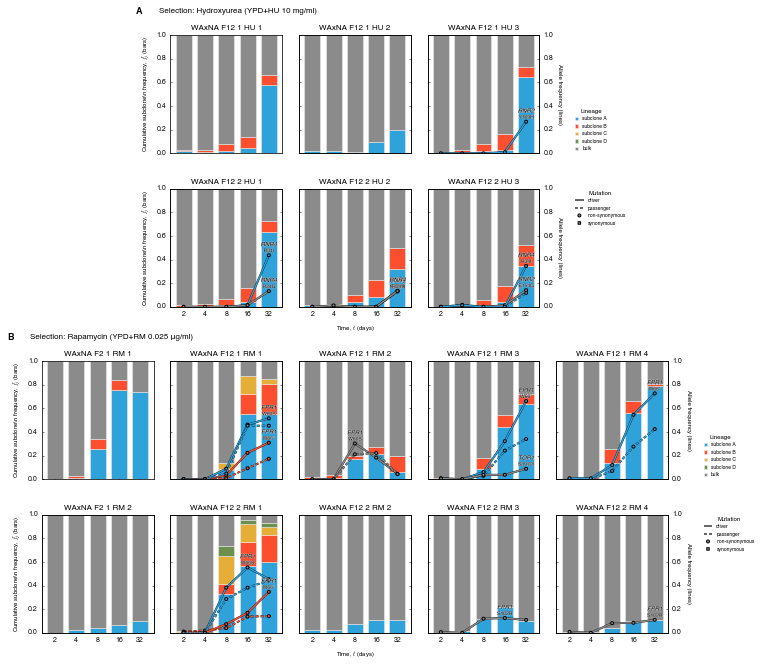

In [9]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':(0,1), 
        'WAxNA_F12_1_HU_2':(0,2), 
        'WAxNA_F12_1_HU_3':(0,3), 
        'WAxNA_F12_2_HU_1':(1,1), 
        'WAxNA_F12_2_HU_2':(1,2), 
        'WAxNA_F12_2_HU_3':(1,3)
    },
    'RM': {
        'WAxNA_F2_1_RM_1':(0,0),
        'WAxNA_F12_1_RM_1':(0,1), 
        'WAxNA_F12_1_RM_2':(0,2), 
        'WAxNA_F12_1_RM_3':(0,3), 
        'WAxNA_F12_1_RM_4':(0,4),
        'WAxNA_F2_1_RM_2':(1,0),
        'WAxNA_F12_2_RM_1':(1,1), 
        'WAxNA_F12_2_RM_2':(1,2), 
        'WAxNA_F12_2_RM_3':(1,3), 
        'WAxNA_F12_2_RM_4':(1,4)
    }
}

populations = panels['HU'].keys()+panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)].groupby(['selection','population'])
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(10, 10), dpi=300)

grid = gridspec.GridSpec(2, 1)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 2
    ncols = 5
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0.3, wspace=0.15)
    
    for (jj, p) in enumerate(panels[e]):
        
        # retrieve axes
        ax1 = plt.subplot(gs[e][panels[e][p]])
        ax2 = ax1.twinx()
        
        ### de novo mutations ###
        if (e,p) in groups_dn.groups.keys():

            gdn = groups_dn.get_group((e,p))
                                    
            for (gene, pos, cds, sub, protein_pos, amino_acids, consequence), gdx \
            in gdn.groupby(['gene','pos','cds_position','substitution',\
                            'protein_position','amino_acids','consequence_short']):
                
                assignment = gdx.assignment.unique()[0]
                mutation_type = gdx.mutation_type.unique()[0]
            
                gdx.time = gdx.time.apply(int)
                gdx = gdx.sort_values('time').reset_index(drop=True)
                gdx = gdx.sort_index()

#                 ax2.plot(gdx.index.values, gdx.frequency.values,
#                          color=config.lineages[assignment]['line'],
#                          **utils.merge_two_dicts(config.mutation_type[mutation_type],
#                                                  config.consequence_short[consequence]))
                
                gdx.frequency.plot(ax=ax2, color=config.lineages[assignment]['line'],
                                   **utils.merge_two_dicts(config.mutation_type[mutation_type],
                                                           config.consequence_short[consequence]))
            
                if mutation_type=='driver':
                    index = np.argmax(gdx.frequency)
                    ax2.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                                 textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                                 path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                    ax2.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                                 xy=(index,gdx.frequency[index]), fontsize=5,
                                 textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                                 path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
        
        ### subclone frequency ###
        gst = groups_st.get_group((e,p))
        
        # set title
        ax1.set_title(p.replace('_',' '), fontsize=8)

        # bar plot
        gst = gst.set_index('time')
        gst = gst[['subclone A','subclone B','subclone C','subclone D','bulk']]
        gst.plot(ax=ax1, kind='bar',
                 legend=False, stacked=True, width=0.75, position=0.5,
                 color=[config.lineages[c]['fill'] for c in gst.columns])

#     for (jj, p) in enumerate(panels[e]):

#         ax2 = plt.subplot(gs[e][panels[e][p]])#.twinx()
        
        # legends
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4')]:
            
            leg1 = ax1.legend(bbox_to_anchor=(1.3, 0), ncol=1,
                              frameon=False, loc='lower left', 
                              borderaxespad=0., handlelength=0.7, 
                              title='Lineage', prop={'size':5})
            plt.setp(leg1.get_title(), fontsize=6)
    
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            
            driver_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                         **config.mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.lineages['bulk']['fill'], 
                                            **config.mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.consequence_short['synonymous'])
            leg2 = ax1.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                              ['driver','passenger','non-synonymous','synonymous'], 
                              bbox_to_anchor=(1.3, 1), ncol=1,
                              frameon=False, loc='upper left',
                              borderaxespad=0, handlelength=1.75, 
                              title='Mutation', prop={'size':5})
            plt.setp(leg2.get_title(),fontsize=6)
            
        # rotate the x-axis ticks
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
        ax1.set_xlabel('')
        
#         ax2.set_xticklabels( ax1.get_xticklabels() )
        
        ax1.set_xticklabels([2,4,8,16,32])
        ax2.set_xticklabels([2,4,8,16,32])
        
#         ax2.set_zorder(ax1.get_zorder()+1) # put ax in front of ax2
#         ax1.patch.set_visible(False) # hide the 'canvas' 
#         ax2.patch.set_visible(False) # hide the 'canvas' 

        if (e,p) in [('HU','WAxNA_F12_2_HU_2'),('RM','WAxNA_F12_2_RM_2')]:
            ax1.set_xlabel(r'Time, $t$ (days)')
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1'),
                     ('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F2_1_RM_2')]:
            ax1.set_ylabel(r'Cumulative subclone\n frequency, $f_j$ (bars)')
        else:
            ax1.set_yticklabels([])
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4'),
                     ('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            ax2.set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
        else:
            ax2.set_yticklabels([])

    # set panel labels
    ax = plt.subplot(gs[e][((0,1) if e == 'HU' else (0,0))])
    ax.text(-0.25, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=9, fontweight='bold', va='center', ha='right')
    ax.text(-0.1, 1.2, 'Selection: %s' % config.selection['long_label'][e],
            transform=ax.transAxes, fontsize=8, va='center', ha='left')
    
# axes limits
for ax in fig.get_axes():
            
    ax.set_ylim(0, 1)

    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
            
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.75)

fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_subclonal_dynamics/supp_figure_seq_subclonal_dynamics_cross.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S5:** Subclonal dynamics in time for WAxNA founders evolved in (**A**) hydroxyurea and (**B**) rapamycin, measured by whole-population sequencing. Time is on the $x$-axis, starting after crossing when the population has no competing clones. Cumulative haplotype frequency of subclones (bars) and allele frequency of *de novo* mutants (lines) are on the $y$-axis. Driver mutations are solid lines and passenger mutations are dashed lines, colored by subclone assignment; circles and squares denote non-synonymous and synonymous mutations, respectively. No macroscopic clones or *de novo* mutations were detected in any of the control replicates in YPD.

## Figure S7 - Phenotype evolution

We are inferring the model's components ($\tau, \lambda_1, \lambda_2$) using a mixture model.

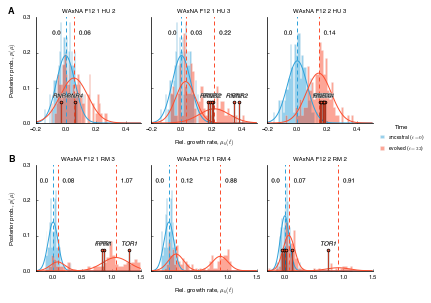

In [10]:
panels = {
    'WAxNA_F12_1_HU_2':(0,0),
    'WAxNA_F12_1_HU_3':(0,1),
    'WAxNA_F12_2_HU_3':(0,2),
    'WAxNA_F12_1_RM_3':(1,0),
    'WAxNA_F12_1_RM_4':(1,1),
    'WAxNA_F12_2_RM_2':(1,2)
}

groups_ph = pheno_df[pheno_df.population.isin(panels.keys())]
groups_ph = groups_ph.groupby(['selection','environment'])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=300, sharex='row', sharey='row')
    
fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.4,wspace=0.1)

for (ii, env) in enumerate(['HU','RM']):
    
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):
        
        # retrieve axes
        ax1 = axes[panels[population]]
        utils.simple_axes(ax1)
        if env=='HU':
            ax1.set_xlim(-0.2, 0.5)
            ax1.set_ylim(0, 0.3)
        elif env=='RM':
            ax1.set_xlim(-0.3, 1.5)
            ax1.set_ylim(0, 0.3)

        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
                
        for (kk, ((time),g3)) in enumerate(gph.groupby('group')):
            
            data = g3.groupby(['isolate']).agg([np.mean])
            X = data[param]['mean'][:, np.newaxis]
            
            # fit the Gaussian mixture model
            N = np.arange(1, 6)
            models = gmm.gmm_fit(X, N)

            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            M_best = models[np.argmin(BIC)]

            ax1.set_title(population.replace('_',' '), fontsize=6)
            
            # plot data
            bins = 34
            xbins, y = plot.histogram_binned_data(ax1, X, bins=bins)
                        
            ax1.fill_between(xbins, 0, y, label=config.population['long_label'][time], 
                             alpha=0.5, facecolor=config.population['color'][time])
            
            xbins = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 1000)
            logprob, responsibilities = M_best.score_samples(np.array([xbins]).T)
            pdf = np.exp(logprob)
            pdf_individual = responsibilities * pdf[:, np.newaxis] 
            
#             ax1.plot(xbins, pdf / bins, '-', 
#                      color='k', lw=.5, 
#                      path_effects=[PathEffects.withStroke(linewidth=1.25, foreground=config.population['color'][time])])
            ax1.plot(xbins, pdf_individual / bins, '-', 
                     color=config.population['color'][time], lw=1)

            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax1.plot( [p,p], ax.get_ylim(), 
                        color=config.population['color'][time], 
                        linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax1.get_ylim()[0] * 0.75 + ax1.get_ylim()[1] * 0.25
                trans = ax1.get_xaxis_transform() # x in data units, y in axes fraction
                ax1.annotate(np.around(p, 2),
                             xy=(p, 0.85), xycoords=trans, fontsize=6,
                             color='k', va='center',
                             ha=('right' if time=='ancestral' else 'left'),
                             xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
                
            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax1.get_ylim()[1]-ax1.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax1.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax1.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])

# draw legend
leg = axes[0, 2].legend(bbox_to_anchor=(1.05, -0.15), frameon=False,
                        loc='center left', borderaxespad=0.,
                        handlelength=0.75, title='Time', prop={'size':5})
plt.setp(leg.get_title(),fontsize=6)

# set axes labels
for ii in [0, 1]:
    axes[ii, 1].set_xlabel(r'Rel. growth rate, $\mu_{k}(t)$')
    axes[ii, 0].set_ylabel(r'Posterior prob., $p(\mu)$')

# set panel labels
axes[0][0].text(-0.2, 1.1,  chr(ord('A')), transform=axes[0][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
axes[1][0].text(-0.2, 1.1,  chr(ord('B')), transform=axes[1][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
        
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)
        
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_evolution/supp_figure_pheno_evolution.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S7:** Variability in intra-population growth rate, estimated by random sampling of 96 individuals at initial (0 days, blue) and final time~points (32 days, red) for populations evolved in hydroxyurea (**A**) and rapamycin (**B**). The average growth rate $\mu$ per individual $k$ is shown, with ${n = 32}$ technical replicates per individual (see Fig. 2, C and D). Using a mixture model, we found the posterior probability of the best-fit mixture (solid) and the mixture modes (dashed). The posterior means of the distribution modes are indicated as dashed lines. The fittest individuals (pins) carry driver mutations, measured by targeted sampling and sequencing.